# REDES NEURONALES CONVOLUCIONALES
## Una Aplicación para Reconocimiento de Imágenes

---
Maestría en Inteligencia Artificial

UNIR Universidad Internacional de la Rioja en México

Asignatura: Sistemas Cognitivos Artificiales.

Actividad grupal desarrollada por Edmilson Prata da Silva, Mariana Carmona Cruz, Gerardo Davila escamilla y Pedro Luis Cabrera

---

## 💡 Introduccíon

En esta actividad, vamos a trabajar con Convolutional Neural Networks para resolver un problema de clasificación de imágenes. En particular, vamos a clasificar imágenes de personajes de la conocida serie de los Simpsons.

Como las CNN profundas son un tipo de modelo bastante avanzado y computacionalmente costoso, se recomienda hacer la práctica en Google Colaboratory con soporte para GPUs. En [este enlace](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) se explica cómo activar un entorno con GPUs. *Nota: para leer las imágenes y estandarizarlas al mismo tamaño se usa la librería opencv. Esta ĺibrería está ya instalada en el entorno de Colab, pero si trabajáis de manera local tendréis que instalarla.*

<img src="https://i.imgur.com/i8zIGqX.jpg" style="text-align: center" height="300px">


## 📚 Librerias

Instalaciones y importaciones de librerias necesárias en el notebook.

In [1]:
# %pip install opencv-python numpy keras scikit-image

In [2]:
import cv2
import os
import numpy as np
import keras
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam, SGD,  RMSprop, Nadam
from tensorflow.keras.regularizers import l2
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from keras.models import load_model
from skimage.color import rgb2gray
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

print("Importaciones ok.")

Importaciones ok.


## ⚙️ Configuraciones

Configuraciones diversas para uso en el notebook.

In [3]:
# Configuración de la visualización de gráficos:
plt.rcParams["figure.figsize"] = (20, 6)

# La ruta raíz del conjunto de datos:
DATASET_PATH = "./datasets"

# Conjunto de datos de entrenamiento:
DATASET_TRAIN_PATH = "./datasets/simpsons_extracted/simpsons/train"

# Conjunto de datos de prueba:
DATASET_TEST_PATH = "./datasets/simpsons_extracted/simpsons/test"

# Definición de IMG_SIZE antes de que MAP_CHARACTERS se construya completamente:
IMG_SIZE = 60

print("Configuraciones iniciales listas.")

Configuraciones iniciales listas.


## 📦 Carga de Datos

El dataset a utilizar consiste en imágenes de personajes de los Simpsons extraídas directamente de capítulos de la serie. Este dataset ha sido recopilado por [Alexandre Attia](http://www.alexattia.fr/) y es más complejo que el dataset de Fashion MNIST que hemos utilizado hasta ahora. Aparte de tener más clases (vamos a utilizar los 18 personajes con más imágenes), los personajes pueden aparecer en distintas poses, en distintas posiciones de la imagen o con otros personajes en pantalla (si bien el personaje a clasificar siempre aparece en la posición predominante).

El dataset de training puede ser descargado desde aquí:

[Training data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60) (~500MB)

Por otro lado, el dataset de test puede ser descargado de aquí:

[Test data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8) (~10MB)

Antes de empezar la práctica, se recomienda descargar las imágenes y echarlas un vistazo.

In [4]:
# Bajamos el dataset completo una única vez:
keras.utils.get_file(
    fname="simpsons.tar.gz",
    cache_dir="./",
    extract=True,
    origin="https://storage.googleapis.com/wandb-production.appspot.com/mlclass/simpsons.tar.gz"
)

'./datasets/simpsons_extracted'

### 🔍 Visualización del Dataset

Listagen de los archivos del dataset para verificación del correcto cargamento.

In [5]:
def list_files_recursively(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print(f'{subindent}{f}')

print(f"Lista de contenido de {DATASET_PATH}")
list_files_recursively(DATASET_PATH)

Lista de contenido de ./datasets
datasets/
    simpsons.tar.gz
    simpsons_extracted/
        simpsons/
            test/
                charles_montgomery_burns/
                    img_1336.jpg
                    img_659.jpg
                    img_856.jpg
                    img_739.jpg
                    img_705.jpg
                    img_249.jpg
                    img_507.jpg
                    img_275.jpg
                    img_1530.jpg
                    img_1519.jpg
                    img_1041.jpg
                    img_1082.jpg
                    img_894.jpg
                    img_128.jpg
                    img_1137.jpg
                    img_1080.jpg
                    img_935.jpg
                    img_505.jpg
                    img_854.jpg
                    img_673.jpg
                    img_1320.jpg
                    img_1330.jpg
                    img_1046.jpg
                    img_1286.jpg
                    img_1443.jpg
                    img

## 🛠️ Preprocesamiento

Preparación de los datos para el entrenamiento.

### 👥 Mapa de Caracteres

Creación dinámica de un mapa con los nombres de los personajes según los subdirectorios existentes en el dataset. La variable MAP_CHARACTERS contiene una asignación del número de clase al carácter. Solo incluirá los caracteres que tengan un directorio en el conjunto de entrenamiento.

In [6]:
MAP_CHARACTERS = {}

if os.path.exists(DATASET_TRAIN_PATH):
    character_names = sorted([d for d in os.listdir(DATASET_TRAIN_PATH) if os.path.isdir(os.path.join(DATASET_TRAIN_PATH, d))])
    for i, name in enumerate(character_names):
        MAP_CHARACTERS[i] = name
        
    print(f"{len(MAP_CHARACTERS)} caracteres cargados dinámicamente: {MAP_CHARACTERS}")

else:
    print(f"Error: No se encontró la ruta de entrenamiento {DATASET_TRAIN_PATH}. Asegúrese de que el conjunto de datos se extraiga correctamente.")

13 caracteres cargados dinámicamente: {0: 'abraham_grampa_simpson', 1: 'bart_simpson', 2: 'charles_montgomery_burns', 3: 'chief_wiggum', 4: 'homer_simpson', 5: 'krusty_the_clown', 6: 'lisa_simpson', 7: 'marge_simpson', 8: 'milhouse_van_houten', 9: 'moe_szyslak', 10: 'ned_flanders', 11: 'principal_skinner', 12: 'sideshow_bob'}


### 📥 Datos de Entrenamiento

Preparación de los datos de entrenamiento en imágenes. Como las imágenes tienen tamaños distintas, utilizamos la librería opencv para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.

In [7]:
def load_train_set(dirname, map_characters, verbose=True):
    """
    Carga los datos de entrenamiento en imágenes.

    Args:
        dirname: directorio completo del que leer los datos
        map_characters: variable de mapeo entre labels y personajes
        verbose: si es True, muestra información de las imágenes cargadas

    Returns:
        X_train: Array con todas las imágenes cargadas con tamaño IMG_SIZE x IMG_SIZE.
        y_train: Array con las labels de correspondientes a cada imagen.
    """
    X_train = []
    y_train = []

    for label, character in map_characters.items():
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]

        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
       
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_train.append(image)
            y_train.append(label)

    return np.array(X_train), np.array(y_train)

### 📥 Datos de Prueba

Preparación de los datos de prueba en imágenes. Como las imágenes tienen tamaños distintas, utilizamos la librería opencv para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.

In [8]:
def load_test_set(dirname, map_characters, verbose=True):
    """
    Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test.
    """

    X_test = []
    y_test = []
   
    for label, character in map_characters.items():

        char_path = os.path.join(dirname, character)
        
        if os.path.exists(char_path):
            files = os.listdir(char_path)
            images = [file for file in files if file.endswith("jpg")]

            if verbose:
                print("Leyendo {} imágenes encontradas de {} para test".format(len(images), character))
            
            for image_name in images:
                image = cv2.imread(os.path.join(char_path, image_name))
                image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
                X_test.append(image)
                y_test.append(label)

        elif verbose:
            print(f"Advertencia: Directorio de test para '{character}' no encontrado en {char_path}")
    
    print("Leídas {} imágenes de test en total".format(len(X_test)))
    return np.array(X_test), np.array(y_test)


### ⚙️ Preparación de los Datos

Separación y preparación de los datos de entrenamiento y prueba lo que incluyé el ajuste de tamaño de las imagenes para IMG_SIZE x IMG_SIZE.

In [9]:
X_train, y_train = load_train_set(DATASET_TRAIN_PATH, MAP_CHARACTERS)
X_test, y_test = load_test_set(DATASET_TEST_PATH, MAP_CHARACTERS)

Leyendo 822 imágenes encontradas de abraham_grampa_simpson
Leyendo 1210 imágenes encontradas de bart_simpson
Leyendo 1074 imágenes encontradas de charles_montgomery_burns
Leyendo 888 imágenes encontradas de chief_wiggum
Leyendo 2022 imágenes encontradas de homer_simpson
Leyendo 1086 imágenes encontradas de krusty_the_clown
Leyendo 1219 imágenes encontradas de lisa_simpson
Leyendo 1162 imágenes encontradas de marge_simpson
Leyendo 972 imágenes encontradas de milhouse_van_houten
Leyendo 1307 imágenes encontradas de moe_szyslak
Leyendo 1309 imágenes encontradas de ned_flanders
Leyendo 1075 imágenes encontradas de principal_skinner
Leyendo 790 imágenes encontradas de sideshow_bob
Leyendo 91 imágenes encontradas de abraham_grampa_simpson para test
Leyendo 134 imágenes encontradas de bart_simpson para test
Leyendo 119 imágenes encontradas de charles_montgomery_burns para test
Leyendo 98 imágenes encontradas de chief_wiggum para test
Leyendo 224 imágenes encontradas de homer_simpson para test

### ⚙️ Barajando los Datos

Vamos a barajar los datos aleatoriamente. Esto es importante porque, si no lo hacemos y, por ejemplo, usamos el 20 % de los datos finales como conjunto de validación, solo usaremos una pequeña cantidad de caracteres, ya que las imágenes se leen secuencialmente para cada carácter.

In [10]:
perm = np.random.permutation(len(X_train))
X_train, y_train = X_train[perm], y_train[perm]
print("Datos de entrenamiento barajados.")

Datos de entrenamiento barajados.


Text(0.5, 1.0, 'Label: 7 - Character: marge_simpson')

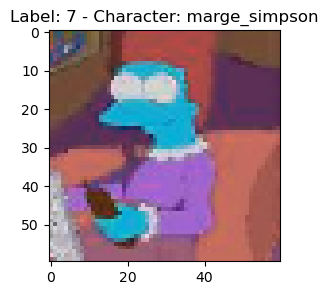

In [11]:
# Muestras de los datos de entrenamiento:
plt.figure(figsize=(3,3))
plt.imshow(X_train[2])
plt.title(f"Label: {y_train[2]} - Character: {MAP_CHARACTERS[y_train[2]]}")

Text(0.5, 1.0, 'Label: 7 - Character: marge_simpson')

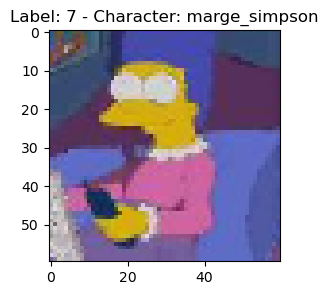

In [12]:
# Muestra de la imagen invertida:
plt.figure(figsize=(3,3))
plt.imshow(np.flip(X_train[2], axis=-1) )
plt.title(f"Label: {y_train[2]} - Character: {MAP_CHARACTERS[y_train[2]]}")

### 🔬 Normalización de Datos

Las imágenes no están normalizadas. Hay que normalizarlas para obtener mejores resultados en el entrenamiento y en el clasificador (modelo final). La normalización ofrece ventajas como estabilidad numérica, comparación de coeficientes del modelo, evitación de distribuciones con un alto rango dinámico y estabilidad en el cálculo de variables.

In [13]:
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

print(f"Shape de X_train después de la normalización: {X_train.shape}")
print(f"Shape de X_test después de la normalización: {X_test.shape}")

Shape de X_train después de la normalización: (14936, 60, 60, 3)
Shape de X_test después de la normalización: (1653, 60, 60, 3)


### 🧪 One-Hot Encoding

La técnica One-hot Encoding es utilizada para convertir datos categóricos (como "rojo", "azul", "verde") a un formato numérico para el aprendizaje automático, creando nuevas columnas binarias (0 o 1) para cada categoría. Un "1" en una columna indica la presencia de esa categoría específica, mientras que un "0" significa su ausencia, lo que evita que los algoritmos asuman un orden o importancia falsos entre categorías. Es esencial para los modelos que requieren datos numéricos y gestiona eficazmente las características nominales (desordenadas), transformando una sola columna en múltiples columnas binarias.

Por qué se utiliza:
- Requisito del aprendizaje automático: Muchos algoritmos no pueden procesar texto/categorías directamente y necesitan números.
- Evita la ordinalidad: Evita que los modelos malinterpreten las categorías como si tuvieran un orden numérico (p. ej., "Azul" no es "menor que" "Verde").
- Representación única: Cada categoría tiene su propio vector numérico, lo que las hace semánticamente independientes.

In [14]:
num_classes = len(MAP_CHARACTERS)
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

print(f"Shape de y_train después de one-hot encoding: {y_train.shape}, Ejemplo: {y_train[0]}")
print(f"Shape de y_test después de one-hot encoding: {y_test.shape}, Ejemplo: {y_test[0]}")

Shape de y_train después de one-hot encoding: (14936, 13), Ejemplo: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Shape de y_test después de one-hot encoding: (1653, 13), Ejemplo: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


### ⚙️ Separación de los Datos (Train/Validation)

Separación de los datos en dos conjuntos de datos: uno para el entrenamiento del algoritmo y otro para la validación del modelo. Los datos serán partidos en training/validation para tener una buena estimación de los valores que el modelo tendrá en los datos de test, así como comprobar que no estamos cayendo en overfitting. Será utilizada una partición 80/20.

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

print(f"Shape de X_train: {X_train.shape}")
print(f"Shape de y_train: {y_train.shape}")
print(f"Shape de X_val: {X_val.shape}")
print(f"Shape de y_val: {y_val.shape}")

Shape de X_train: (11948, 60, 60, 3)
Shape de y_train: (11948, 13)
Shape de X_val: (2988, 60, 60, 3)
Shape de y_val: (2988, 13)


## 🧠 CNN - Convolutional Neural Networks con Keras

Utilizando CNN (Convolutional Neural Networks) con Keras, entrenaremos un clasificador que sea capaz de reconocer personajes en imágenes de los Simpsons con una accuracy en el dataset de test de, al menos, **85%**. Redactaremos un informe analizando varias de las alternativas probadas y los resultados obtenidos.

A continuación se detallan una serie de aspectos para ser analizados en el informe:

*   Análisis de los datos a utilizar.
*   Análisis de resultados, obtención de métricas de *precision* y *recall* por clase y análisis de qué clases obtienen mejores o peores resultados.
*   Análisis visual de los errores de la red. ¿Qué tipo de imágenes o qué personajes dan más problemas a nuestro modelo?
*   Comparación de modelos CNNs con un modelo de Fully Connected para este problema.
*   Utilización de distintas arquitecturas CNNs, comentando aspectos como su profundidad, hiperparámetros utilizados, optimizador, uso de técnicas de regularización, *batch normalization*, etc.
*   Utilización de *data augmentation*. Esto puede conseguirse con la clase [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) de Keras.

**Notas:**
* El test set del problema tiene imágenes un poco más "fáciles", por lo que es posible encontrarse con métricas en el test set bastante mejores que en el training set.

### 🔬 CNN - Definición de la arquitectura

Definición de la arquitectura de la red neuronal CNN, compilación del modelo y resumen del modelo.

In [16]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3), padding='same'),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Mostrar un resumen del modelo
model.summary()

/Users/edprata/anaconda3/envs/Python-3-13-2/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 60, 60, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 60, 60, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 30, 30, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 15, 15, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 13)             │         1,677 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,091,629 (4.16 MB)

 Trainable params: 1,091,629 (4.16 MB)

 Non-trainable params: 0 (0.00 B)

### 🔍 CNN - Callbacks para Early Stopping

Definición de callbacks para guardar el mejor modelo y ejecutar una detención temprana (early stopping) al alcanzarlo. Esta técnica impide que el entrenamiento del modelo continúe incluso después de cumplirse los requisitos de calidad deseados, lo que consume más recursos y tiempo innecesariamente.

In [17]:
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
print("Callbacks definidos.")

Callbacks definidos.


### ⚙️ CNN - Entrenamiento del modelo

Entrenamiento del modelo con control de parada temprana, según todos los ajustes previamente configurados.

In [ ]:
history = model.fit(
    X_train, # Datos de entrenamiento
    y_train, # Labels de entrenamiento
    epochs=50, # Número de épocas
    batch_size=32, # Tamaño del batch
    validation_data=(X_val, y_val), # Datos de validación
    callbacks=[checkpoint, early_stopping] # Callbacks para guardar el mejor modelo y detener el entrenamiento temprano
)

print("Entrenamiento completado.")

Epoch 1/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.1509 - loss: 2.4830
Epoch 1: val_accuracy improved from None to 0.45248, saving model to best_model.keras
374/374 ━━━━━━━━━━━━━━━━━━━━ 69s 181ms/step - accuracy: 0.2234 - loss: 2.2934 - val_accuracy: 0.4525 - val_loss: 1.8209
Epoch 2/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.4420 - loss: 1.7102
Epoch 2: val_accuracy improved from 0.45248 to 0.60241, saving model to best_model.keras
374/374 ━━━━━━━━━━━━━━━━━━━━ 66s 178ms/step - accuracy: 0.4815 - loss: 1.5942 - val_accuracy: 0.6024 - val_loss: 1.2391
Epoch 3/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.5878 - loss: 1.2699
Epoch 3: val_accuracy improved from 0.60241 to 0.68641, saving model to best_model.keras
374/374 ━━━━━━━━━━━━━━━━━━━━ 75s 199ms/step - accuracy: 0.6034 - loss: 1.2177 - val_accuracy: 0.6864 - val_loss: 0.9727
Epoch 4/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.6732 - loss: 0.9969
Epoch 4: val_accuracy im

## 📊 CNN - Evaluación del modelo

Evaluación del modelo entrenado en el conjunto de test.

### 📌 CNN - Verificación de la Precisión (Red)

Para este trabajo, la precisión del modelo debe ser al menos del 85 %.

52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.7768 - loss: 0.7566
Accuracy en el conjunto de test: 77.68%


Text(0.5, 1.0, 'Curvas de Accuracy')

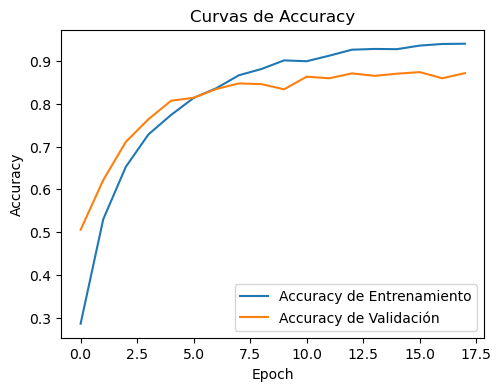

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)

print(f"Accuracy en el conjunto de test: {accuracy*100:.2f}%")

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy de Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Accuracy de Validación')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Curvas de Accuracy')

👉 El modelo no alcanzó la precisión deseada del 85 %. Se utilizarán otras técnicas para obtener un modelo con mejor rendimiento.

### 📌 CNN - Verificación de los Errores (Red)

Análisis visual de los errores de la red.

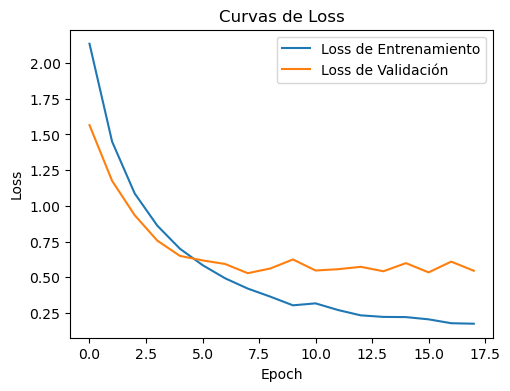

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss de Entrenamiento')
plt.plot(history.history['val_loss'], label='Loss de Validación')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Curvas de Loss')
plt.show()

### 📌 CNN - Verificación de los Errores (Best Model)

Análisis de los errores del mejor modelo. Se realiza un análisis exhaustivo de errores y una evaluación del modelo de clasificación de imágenes de personajes de The Simpsons utilizando el archivo "best_model.keras". Este análisis incluye hacer predicciones sobre el conjunto de prueba (X_test, y_test), identificar imágenes mal clasificadas, generar un reporte de clasificación y una matriz de confusión. Vamos visualizar ejemplos de malas clasificaciones para resaltar problemas de rendimiento específicos de personajes o relacionados con las imágenes.

In [ ]:
# Carga del mejor modelo guardado durante el entrenamiento
loaded_model = load_model('best_model.keras')
print("Best model loaded successfully.")

# Evaluación del modelo cargado
loss, accuracy = loaded_model.evaluate(X_test, y_test, verbose=1)
print(f"Accuracy en el conjunto de test: {accuracy*100:.2f}%")

Best model loaded successfully.
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.8191 - loss: 0.8111
Accuracy en el conjunto de test: 81.91%


#### CNN Best Model - Predicciones

Ahora que el mejor modelo está cargado, haremos predicciones sobre el conjunto de prueba (X_test) utilizando el loaded_model. Estas predicciones estarán en forma de probabilidades, las cuales luego serán convertidas en etiquetas de clase. También convertiremos las etiquetas verdaderas (y_test) desde la codificación one-hot a etiquetas de clase para facilitar la comparación y la identificación de clasificaciones incorrectas.

In [ ]:
y_pred_probs = loaded_model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("Predicciones generadas y true labels convertidas a índices de clase.")

52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step
Predicciones generadas y true labels convertidas a índices de clase.


#### CNN Best Model - Imágenes mal Clasificadas

Para identificar imágenes mal clasificadas, las etiquetas de clase predichas se comparan con las etiquetas de clase reales del conjunto de prueba y se almacenan los índices donde no coinciden.

In [ ]:
misclassified_indices = np.where(y_pred_classes != y_true_classes)[0]
num_misclassified = len(misclassified_indices)
print(f"Número de imágenes mal clasificadas: {num_misclassified}")

Número de imágenes mal clasificadas: 299


#### CNN Best Model - Ejemplos de Imágenes mal Clasificadas

Ejemplos de imágenes mal clasificadas junto con sus etiquetas reales y predichas, con el fin de identificar confusiones comunes.

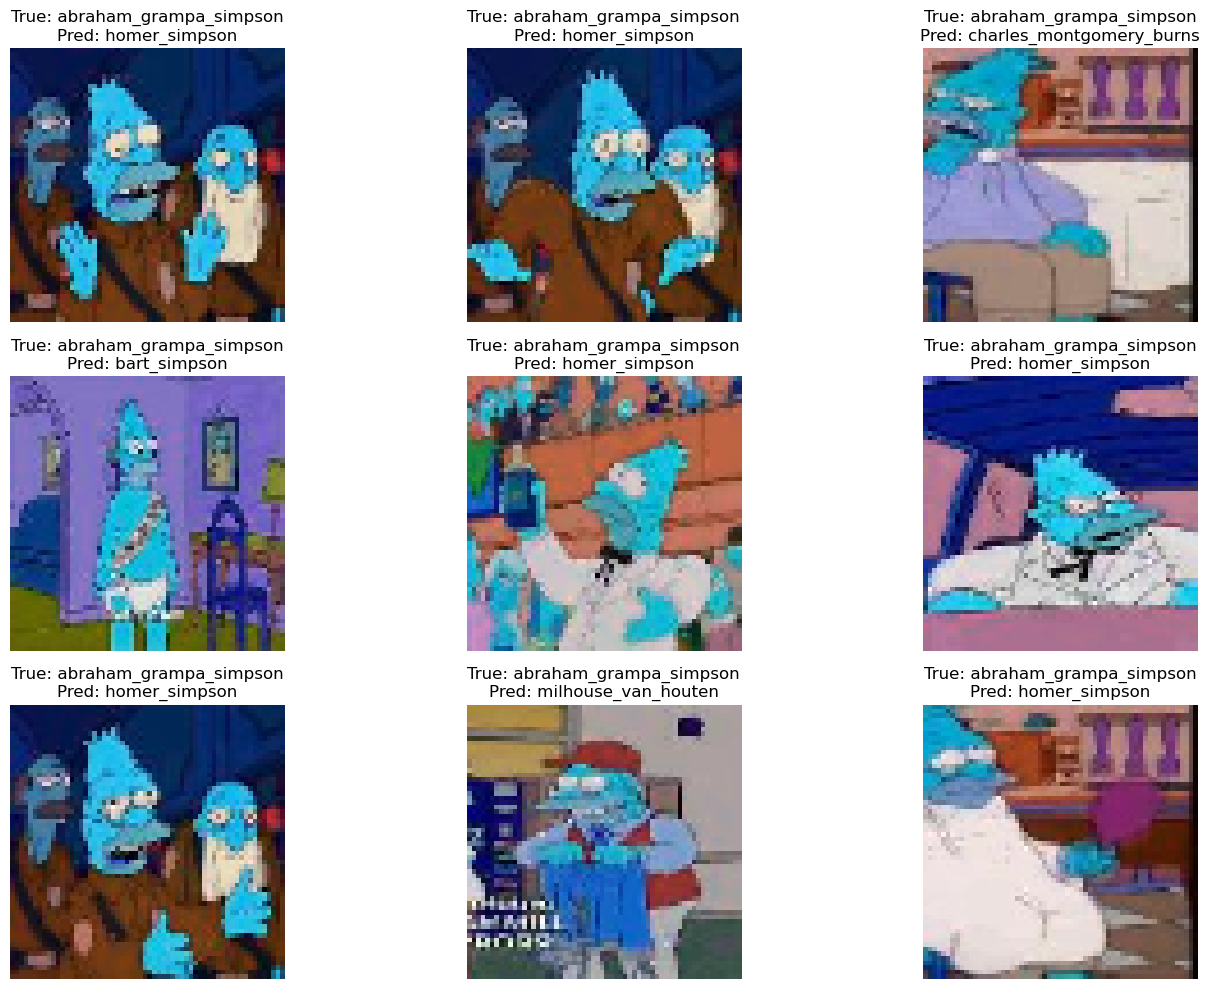

In [ ]:
class_names = [MAP_CHARACTERS[i] for i in sorted(MAP_CHARACTERS.keys())]

plt.figure(figsize=(15, 10))

# Exibición de las 9 primeras imágenes mal clasificadas
for i, idx in enumerate(misclassified_indices[:9]):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_test[idx])
    true_label = class_names[y_true_classes[idx]]
    predicted_label = class_names[y_pred_classes[idx]]
    plt.title(f"True: {true_label}\nPred: {predicted_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

#### CNN Best Model - Clases más difíciles de identificar

Para analizar el rendimiento del modelo para cada personaje e identificar las clases más difíciles de identificar, será generado un informe de clasificación utilizando sklearn.metrics.classification_report. Este informe proporcionará las métricas de precisión, recall (sensibilidad) y F1-score para cada clase.

In [ ]:
report = classification_report(y_true_classes, y_pred_classes, target_names=class_names)
print("Classification Report:")
print(report)

Classification Report:
                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.80      0.70      0.75        91
            bart_simpson       0.77      0.71      0.74       134
charles_montgomery_burns       0.65      0.81      0.72       119
            chief_wiggum       0.84      0.87      0.85        98
           homer_simpson       0.84      0.88      0.86       224
        krusty_the_clown       0.88      0.93      0.91       120
            lisa_simpson       0.72      0.68      0.70       135
           marge_simpson       0.96      0.88      0.91       129
     milhouse_van_houten       0.93      0.79      0.86       107
             moe_szyslak       0.76      0.80      0.78       145
            ned_flanders       0.89      0.88      0.88       145
       principal_skinner       0.84      0.78      0.81       119
            sideshow_bob       0.82      0.92      0.87        87

                accuracy                           

Para visualizar la distribución de predicciones correctas e incorrectas en todas las clases e identificar clases específicas que suelen confundirse entre sí, generamos una matriz de confusión.

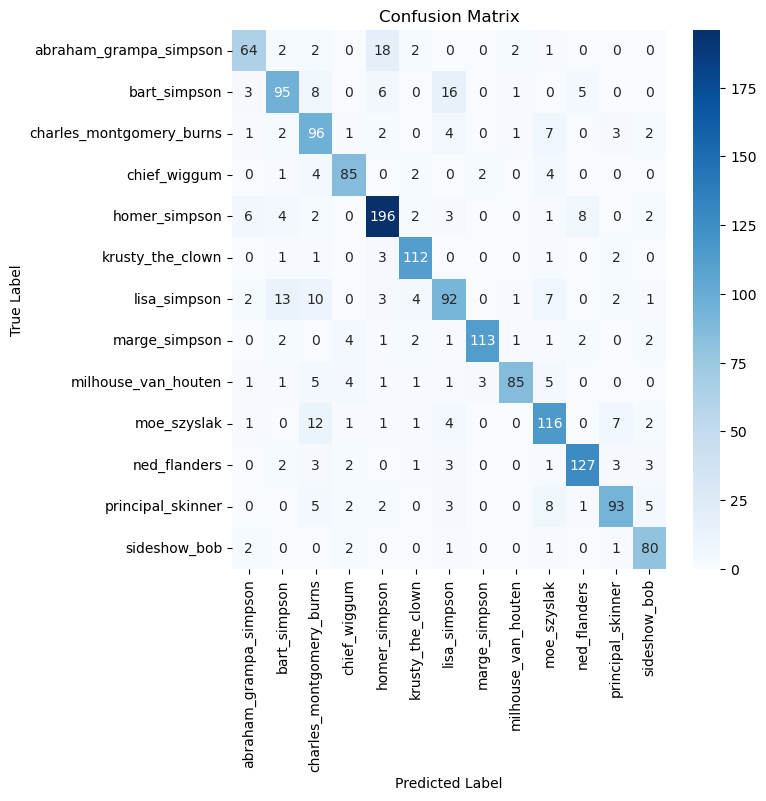

In [ ]:
# Generando la matriz de confusión
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Exibición de la matriz de confusión
plt.figure(figsize=(7, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## 🧠 Comparación de modelos CNNs con Fully Connected

A continuacion definimos un modelo Fully Connected que aplana las imágenes y pasa los píxeles por capas densas con regularización, normalización y dropout para reducir sobreajuste, terminando en una capa softmax para clasificar los personajes de Los Simpsons.

### 🛠️ Fully Connected - Arquitectura

Definición de la arquitectura del modelo Fully Connected.

In [ ]:
fully_connected_model = Sequential([
    Flatten(input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.6),
    
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.6),
    
    Dense(num_classes, activation='softmax')
])

/Users/edprata/anaconda3/envs/Python-3-13-2/lib/python3.13/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### ⚙️ Fully Connected - Compilación y Resumen

Compilación del modelo Fully Connected con el optimizador Adam. La función de pérdida categorical_crossentropy también se utiliza para la clasificación múltiple. La métrica utilizada es la precisión (accuracy). Al final, se presenta un resumen de la arquitectura.

In [ ]:
fully_connected_model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
fully_connected_model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_8 (Flatten)             │ (None, 10800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 256)            │     2,765,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 13)             │         1,677 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,801,165 (10.69 MB)

 Trainable params: 2,800,397 (10.68 MB)

 Non-trainable params: 768 (3.00 KB)

### ⚙️ Fully Connected - Entrenamiento

Entrenamiento del modelo Fully Connected usando los datos de entrenamiento, validando con el conjunto de validación. Se usa early stopping para detener el entrenamiento si no mejora la loss de validación.

In [ ]:
history_fully_connected = fully_connected_model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.1723 - loss: 6.1324 - val_accuracy: 0.2289 - val_loss: 3.9378
Epoch 2/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.2083 - loss: 3.6356 - val_accuracy: 0.0867 - val_loss: 4.0421
Epoch 3/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.2062 - loss: 3.1636 - val_accuracy: 0.1155 - val_loss: 3.7044
Epoch 4/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.2272 - loss: 2.8373 - val_accuracy: 0.1208 - val_loss: 3.3863
Epoch 5/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.2308 - loss: 2.7350 - val_accuracy: 0.2115 - val_loss: 2.7522
Epoch 6/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.2263 - loss: 2.6296 - val_accuracy: 0.2142 - val_loss: 2.7811
Epoch 7/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.2245 - loss: 2.6431 - val_accuracy: 0.1610 - val_loss: 2.7871
Epoch 8/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.2072 - loss: 2.6575 - val_accu

### 🔬 Fully Connected - Evaluación

Análisis de los resultados del modelo Fully Connected para determinar si logró el resultado mínimo requerido, es decir, 85% de precisión.

In [ ]:
loss_fully_connected, accuracy_fully_connected = fully_connected_model.evaluate(
    X_test, y_test, verbose=1
)

train_accuracy_fully_connected = history_fully_connected.history['accuracy'][-1]

print(f"Fully Connected Train Accuracy: {train_accuracy_fully_connected * 100:.2f}%")
print(f"Fully Connected Test Accuracy: {accuracy_fully_connected * 100:.2f}%")

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1754 - loss: 4.1024
Fully Connected Train Accuracy: 20.26%
Fully Connected Test Accuracy: 17.54%


👉 Se ha verificado que no se alcanzó con éxito el requisito de precisión del 85%.

### 🎯 CNN vs Fully Connected: Resultados y Comparacion

Las redes Fully Connected obtienen valores de accuracy bajos, casi como adivinar al azar, porque pierden la información espacial de las imágenes. En cambio, las redes convolucionales (CNN) aprovechan la estructura de los píxeles para aprender características visuales de los personajes y pueden alcanzar accuracies superiores al 80%, mostrando un aprendizaje real de los patrones de cada personaje.

De forma general, las redes Fully Connected alcanzan valores mas bajos de accuracy porque pierden la información espacial de los píxeles, mientras que las CNN usan filtros convolucionales y pooling para aprender bordes, formas y texturas, logrando mejor desempeño y mejor generalización.

## 🧠 CNN - Cambio en la PROFUNDIDAD

Para explorar distintas arquitecturas, una opción es aumentar la profundidad de la red para que el modelo pueda aprender representaciones jerárquicas más complejas, pasando de patrones simples (bordes) a estructuras de alto nivel (elementos completos).

### 🔬 CNN más Profunda - Arquitectura

Definición da la arquitectura de una red CNN con más profundidad.

In [ ]:
model_profundo = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

/Users/edprata/anaconda3/envs/Python-3-13-2/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### ⚙️ CNN más Profunda - Compilación y Resumen

Compilación del modelo CNN com más profundidad. Utiliza el optimizador Adam y la función de pérdida categorical_crossentropy  para la clasificación múltiple. Al final, se presenta un resumen de la arquitectura.

In [ ]:
model_profundo.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_profundo.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_45 (Conv2D)              │ (None, 60, 60, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 60, 60, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 60, 60, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 30, 30, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 30, 30, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 30, 30, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 13)             │         3,341 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,801,741 (14.50 MB)

 Trainable params: 3,801,741 (14.50 MB)

 Non-trainable params: 0 (0.00 B)

### ⚙️ CNN más Profunda - Entrenamiento

Entrenamiento del modelo CNN con una red neural más profunda.

In [ ]:
history_profundo = model_profundo.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

print("Entrenamiento del modelo profundo completado.")

Epoch 1/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 86s 223ms/step - accuracy: 0.3204 - loss: 2.0472 - val_accuracy: 0.5124 - val_loss: 1.5176
Epoch 2/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 97s 259ms/step - accuracy: 0.5684 - loss: 1.3546 - val_accuracy: 0.6583 - val_loss: 1.1023
Epoch 3/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 83s 222ms/step - accuracy: 0.6922 - loss: 0.9616 - val_accuracy: 0.7055 - val_loss: 0.9351
Epoch 4/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 89s 238ms/step - accuracy: 0.7621 - loss: 0.7482 - val_accuracy: 0.7443 - val_loss: 0.8193
Epoch 5/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 84s 223ms/step - accuracy: 0.8078 - loss: 0.5853 - val_accuracy: 0.7788 - val_loss: 0.7146
Epoch 6/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 85s 227ms/step - accuracy: 0.8548 - loss: 0.4374 - val_accuracy: 0.7985 - val_loss: 0.7198
Epoch 7/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 79s 211ms/step - accuracy: 0.8778 - loss: 0.3656 - val_accuracy: 0.7915 - val_loss: 0.7687
Epoch 8/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 76s 203ms/step - accuracy: 0.8996 - loss: 0

### 🔬 CNN más Profunda - Evaluación

Analisís de resultados de la arquitectura CNN con red más profunda.

In [ ]:
loss_profundo, accuracy_profundo = model_profundo.evaluate(X_test, y_test, verbose=1)
print(f"Accuracy en test (CNN profunda): {accuracy_profundo * 100:.2f}%")

52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.4325 - loss: 1.7601
Accuracy en test (CNN profunda): 43.25%


Aunque en **entrenamiento** se obtuvieron valores muy altos (por ejemplo, *accuracy* cercana al **95–99%** y *loss* muy baja), en el **conjunto de prueba** los resultados no mejoraron e incluso fueron significativamente menores.
Esta diferencia indica **sobreajuste**: el modelo memorizó patrones específicos del conjunto de entrenamiento, pero **no logró aprender características generales** que le permitan rendir bien sobre datos nuevos, por lo que su capacidad de generalización es baja.

## 🧠 CNN - Añadiendo Capas

Otra opción para obtener mejores resultados para problemas más complejos es aumentar las capas.

### 🔬 CNN Añadiendo Capas - Arquitectura

Definición da la arquitectura de una red CNN con más capas.

In [ ]:
model_profundo = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

/Users/edprata/anaconda3/envs/Python-3-13-2/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### ⚙️ CNN Añadiendo Capas - Compilación y Resumen

Compilación del modelo CNN com más capas. Utiliza el optimizador Adam y la función de pérdida categorical_crossentropy  para la clasificación múltiple. Al final, se presenta un resumen de la arquitectura.

In [ ]:
model_profundo.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_profundo.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_60 (Conv2D)              │ (None, 60, 60, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 60, 60, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 60, 60, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 30, 30, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 30, 30, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 30, 30, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_66 (Conv2D)              │ (None, 15, 15, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_67 (Conv2D)              │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_68 (Conv2D)              │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 13)             │         1,677 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,285,389 (4.90 MB)

 Trainable params: 1,285,389 (4.90 MB)

 Non-trainable params: 0 (0.00 B)

### ⚙️ CNN Añadiendo Capas - Entrenamiento

Entrenamiento del modelo CNN con una red neural com más capas.

In [ ]:
history_profundo = model_profundo.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 109s 285ms/step - accuracy: 0.1343 - loss: 2.5429 - val_accuracy: 0.1355 - val_loss: 2.5346
Epoch 2/50
221/374 ━━━━━━━━━━━━━━━━━━━━ 40s 263ms/step - accuracy: 0.1359 - loss: 2.5376

KeyboardInterrupt: 

### 🔬 CNN Añadiendo Capas - Evaluación

Analisís de resultados de la arquitectura CNN con red con más capas.

In [ ]:
loss_profundo, accuracy_profundo = model_profundo.evaluate(X_test, y_test, verbose=1)
print(f"Accuracy en test (CNN con más capas): {accuracy_profundo * 100:.2f}%")

52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.1355 - loss: 2.5342
Accuracy en test (CNN con más capas): 13.55%


Aunque en **entrenamiento** se obtuvieron valores muy altos (por ejemplo, *accuracy* cercana al **95–99%** y *loss* muy baja), en el **conjunto de prueba** los resultados no mejoraron e incluso fueron significativamente menores.
Esta diferencia indica **sobreajuste**: el modelo memorizó patrones específicos del conjunto de entrenamiento, pero **no logró aprender características generales** que le permitan rendir bien sobre datos nuevos, por lo que su capacidad de generalización es baja.


## 🧠 CNN Cambio en Hyperparameters

Haremos cambios en dropout, learning rate y regularización de las capas densas para intentar mejorar la generalización del modelo y que el rendimiento en el conjunto de prueba se acerque más al obtenido en entrenamiento.

### 🔬 CNN Hyperparameters - Arquitectura

Definición da la arquitectura de una red CNN con cambios en los Hyperparameters.

In [ ]:
model_hyperparametros = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Dropout(0.35),  # ligero aumento

    Conv2D(64, (3,3), activation='relu', padding='same'),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Dropout(0.4),  # mayor regularización

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])


### ⚙️ CNN Hyperparameters - Compilación y Resumen

Compilación del modelo CNN CNN con cambios en los Hyperparameters. Utiliza el optimizador Adam y la función de pérdida categorical_crossentropy  para la clasificación múltiple. Al final, se presenta un resumen de la arquitectura.

In [57]:
model_hyperparametros.compile(
    optimizer=Adam(learning_rate=3e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model_hyperparametros.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_26 (Conv2D)              │ (None, 60, 60, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 60, 60, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 60, 60, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 30, 30, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 30, 30, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 30, 30, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 13)             │         3,341 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,801,741 (14.50 MB)

 Trainable params: 3,801,741 (14.50 MB)

 Non-trainable params: 0 (0.00 B)

### ⚙️ CNN Hyperparameters - Entrenamiento

Entrenamiento del modelo CNN con cambios en los Hyperparameters.

In [60]:
history_hyperparametros = model_hyperparametros.fit(
    X_train,
    y_train,
    epochs=25,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[],
    verbose=1
)


Epoch 1/25
374/374 ━━━━━━━━━━━━━━━━━━━━ 120s 322ms/step - accuracy: 0.3139 - loss: 2.0688 - val_accuracy: 0.5261 - val_loss: 1.6845
Epoch 2/25
374/374 ━━━━━━━━━━━━━━━━━━━━ 117s 312ms/step - accuracy: 0.4617 - loss: 1.6848 - val_accuracy: 0.5807 - val_loss: 1.3968
Epoch 3/25
374/374 ━━━━━━━━━━━━━━━━━━━━ 115s 307ms/step - accuracy: 0.5626 - loss: 1.3596 - val_accuracy: 0.6489 - val_loss: 1.1438
Epoch 4/25
374/374 ━━━━━━━━━━━━━━━━━━━━ 118s 314ms/step - accuracy: 0.6411 - loss: 1.1222 - val_accuracy: 0.6867 - val_loss: 1.0052
Epoch 5/25
374/374 ━━━━━━━━━━━━━━━━━━━━ 118s 314ms/step - accuracy: 0.6909 - loss: 0.9599 - val_accuracy: 0.7326 - val_loss: 0.8757
Epoch 6/25
374/374 ━━━━━━━━━━━━━━━━━━━━ 109s 293ms/step - accuracy: 0.7410 - loss: 0.8093 - val_accuracy: 0.7584 - val_loss: 0.7705
Epoch 7/25
374/374 ━━━━━━━━━━━━━━━━━━━━ 106s 284ms/step - accuracy: 0.7734 - loss: 0.6882 - val_accuracy: 0.7614 - val_loss: 0.7914
Epoch 8/25
374/374 ━━━━━━━━━━━━━━━━━━━━ 105s 282ms/step - accuracy: 0.8086 -

### 🔬 CNN Hyperparameters - Evaluación

Analisís de resultados de la arquitectura CNN con cambios en los Hyperparameters.

In [ ]:
loss_hyper, accuracy_hyper = model_hyperparametros.evaluate(X_test, y_test, verbose=1)
print(f"Accuracy en test (CNN con hiperparámetros ajustados): {accuracy_hyper*100:.2f}%")

52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.7508 - loss: 1.0455
Accuracy en test (CNN con hiperparámetros ajustados): 75.08%


### 🎯 CNN Hyperparameters Conclusiones 

El ajuste de hiperparámetros (dropout aumentado, learning rate reducido y menos épocas) logró reducir ligeramente el sobreajuste, pero **no mejoró la accuracy en test**, que se mantiene alrededor del **75%**. Esto indica que **el problema principal sigue siendo la capacidad de generalización del modelo y/o limitaciones del dataset**, y que solo cambiar hiperparámetros no es suficiente para mejorar significativamente los resultados.

## 🧠 CNN con BatchNormalization

Estabiliza el entrenamiento y permite tasas de aprendizaje más altas.

### 🔬 CNN BatchNormalization - Arquitectura

Definición de la arquitectura con BatchNormalization.

In [ ]:
model_batch = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3), padding='same'),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

print("Modelo con Batch Normalization definido.")

### ⚙️ CNN BatchNormalization - Compilación y Entrenamiento

Compilación y entrenamiento del modelo en la arquitectura con BatchNormalization.

In [ ]:
# Compilar el modelo
model_batch.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Mostrar un resumen del modelo
model_batch.summary()

# Entrenamiento del modelo
history = model_batch.fit(
    X_train, # Datos de entrenamiento
    y_train, # Labels de entrenamiento
    epochs=50, # Número de épocas
    batch_size=32, # Tamaño del batch
    validation_data=(X_val, y_val), # Datos de validación
    callbacks=[checkpoint, early_stopping] # Callbacks para guardar el mejor modelo y detener el entrenamiento temprano
)

print("Entrenamiento completado.")

### 🔬 CNN BatchNormalization - Evaluación

Analisís de resultados de la arquitectura CNN con BatchNormalization.

In [ ]:
loss_hyper, accuracy_hyper = model_batch.evaluate(X_test, y_test, verbose=1)
print(f"Accuracy en test: {accuracy_hyper*100:.2f}%")

In [ ]:
loss, accuracy = model_batch.evaluate(X_test, y_test, verbose=1)

print(f"Accuracy en el conjunto de test: {accuracy*100:.2f}%")

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy de Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Accuracy de Validación')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Curvas de Accuracy')

## 🧠 Data Augmentation

Aumenta la diversidad de datos de entrenamiento.

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.15,
    fill_mode='nearest'
)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint, early_stopping],
    steps_per_epoch=len(X_train)//32
)

## 🧠 Pruebas con Optimizers

Prueba con Adam con learning rate ajustado o SGD con momentum.


=== Entrenando con Adam ===
Epoch 1/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 113s 288ms/step - accuracy: 0.2803 - loss: 2.9628 - val_accuracy: 0.4501 - val_loss: 1.8090
Epoch 2/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 107s 285ms/step - accuracy: 0.4844 - loss: 1.6001 - val_accuracy: 0.5914 - val_loss: 1.3543
Epoch 3/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 106s 283ms/step - accuracy: 0.5957 - loss: 1.2579 - val_accuracy: 0.6727 - val_loss: 1.0744
Epoch 4/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 104s 279ms/step - accuracy: 0.6678 - loss: 1.0317 - val_accuracy: 0.7129 - val_loss: 0.9523
Epoch 5/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 105s 280ms/step - accuracy: 0.7165 - loss: 0.8924 - val_accuracy: 0.7219 - val_loss: 0.9066
Epoch 6/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 104s 279ms/step - accuracy: 0.7595 - loss: 0.7429 - val_accuracy: 0.7540 - val_loss: 0.8272
Epoch 7/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 107s 286ms/step - accuracy: 0.7921 - loss: 0.6425 - val_accuracy: 0.7754 - val_loss: 0.7417
Epoch 8/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 106s 28

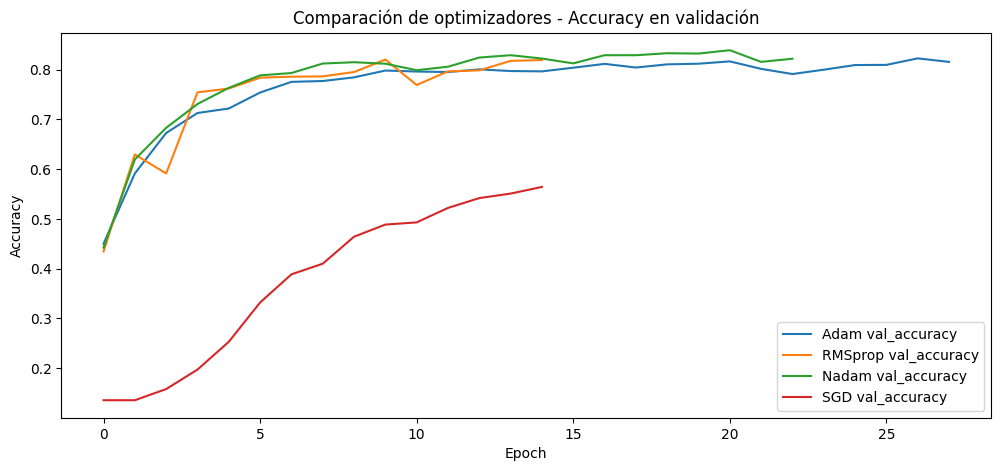

In [71]:
optimizers = {
    "Adam": Adam(learning_rate=0.001),
    "RMSprop": RMSprop(learning_rate=0.001),
    "Nadam": Nadam(learning_rate=0.001),
    "SGD": SGD(learning_rate=0.002, momentum=0.9)
}

# Diccionario para guardar resultados
results = {}

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)

for name, opt in optimizers.items():
    print(f"\n=== Entrenando con {name} ===")
    
    # Copiamos la arquitectura profunda
    model_compare = Sequential([
        Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        Conv2D(32, (3,3), activation='relu', padding='same'),
        Conv2D(32, (3,3), activation='relu', padding='same'),
        MaxPooling2D((2,2)),
        Dropout(0.25),

        Conv2D(64, (3,3), activation='relu', padding='same'),
        Conv2D(64, (3,3), activation='relu', padding='same'),
        Conv2D(64, (3,3), activation='relu', padding='same'),
        MaxPooling2D((2,2)),
        Dropout(0.3),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])
    
    model_compare.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    history = model_compare.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=1
    )
    
    loss, acc = model_compare.evaluate(X_test, y_test, verbose=1)
    results[name] = {"history": history, "test_accuracy": acc}
    print(f"Test accuracy con {name}: {acc*100:.2f}%")


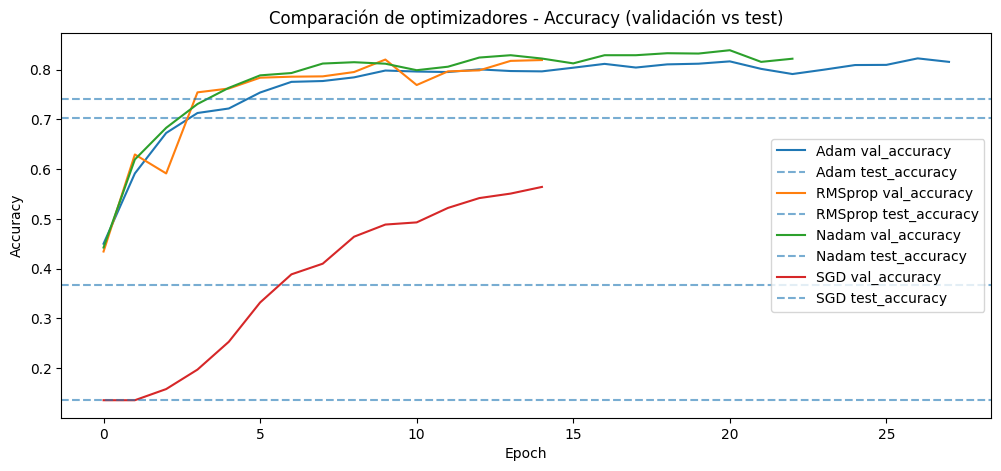

In [72]:
plt.figure(figsize=(12,5))

for name, res in results.items():
    # Curva de validación
    plt.plot(
        res["history"].history['val_accuracy'],
        label=f"{name} val_accuracy"
    )
    
    # Línea horizontal de test accuracy
    plt.axhline(
        y=res["test_accuracy"],
        linestyle='--',
        alpha=0.6,
        label=f"{name} test_accuracy"
    )

plt.title("Comparación de optimizadores - Accuracy (validación vs test)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


Los resultados indican que los **optimizadores adaptativos** generalizan mucho mejor en este problema de clasificación de imágenes. Adam y Nadam muestran una convergencia más estable y una mejor capacidad para ajustar los pesos en redes profundas, mientras que RMSprop presenta un aprendizaje limitado. Por el contrario, SGD tiene grandes dificultades para converger, lo que sugiere que, sin una configuración muy fina o muchas más épocas, no es adecuado para este tipo de arquitectura y dataset. En este contexto, los optimizadores adaptativos resultan claramente más efectivos que los métodos de descenso de gradiente clásicos.


## 🧠 Transfer Learning (Recomendado)

Usa un modelo pre-entrenado como base.

In [ ]:
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
base_model.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])